In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

import cartopy.crs as ccrs                   # import projections
import cartopy
import scipy.signal
from scipy.io import loadmat

## 3x3 deg geo EKE

In [19]:
path='data/fft_ssh_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

lon_plot = lon_plot[1:-1]
lat_plot = lat_plot[1:-1]

fft_h = nc.variables['fft_h_real'][:] \
       + 1j* nc.variables['fft_h_img'][:]

dx = 110e3*0.1
dy = 110e3*0.1
g = 9.8
f_cor = 2.*7.3e-5*np.sin(np.deg2rad(30))
fft_u = - (g/f_cor)*(fft_h[:,2:,1:-1] - fft_h[:,:-2,1:-1])/dy
fft_v = (g/f_cor)*(fft_h[:,1:-1,2:] - fft_h[:,1:-1,:-2])/dx

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]

path='data/fft_ssh_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39_3x3_ave.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

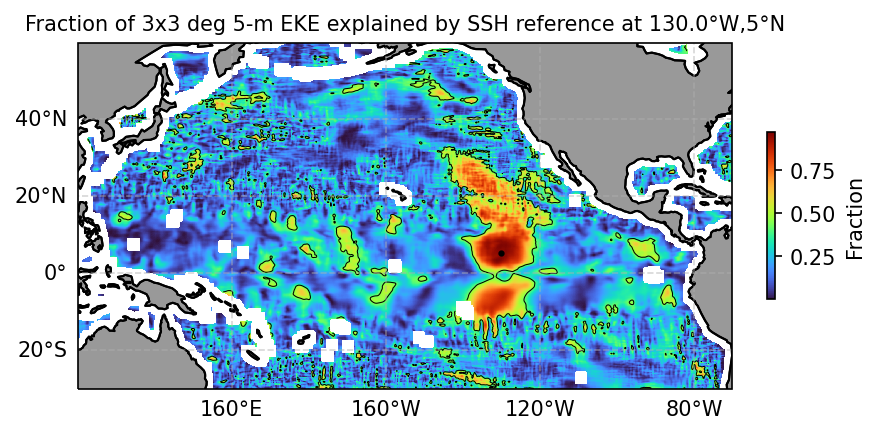

In [20]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 3x3 deg 5-m EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()

## 0.1 deg geo-u,v

In [22]:
path='data/fft_ssh_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39.nc'
nc=Dataset(path,'r')
lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

lon_plot = lon_plot[1:-1]
lat_plot = lat_plot[1:-1]

fft_h = nc.variables['fft_h_real'][:] \
       + 1j* nc.variables['fft_h_img'][:]

dx = 110e3*0.1
dy = 110e3*0.1
g = 9.8
f_cor = 2.*7.3e-5*np.sin(np.deg2rad(30))
fft_u = - (g/f_cor)*(fft_h[:,2:,1:-1] - fft_h[:,:-2,1:-1])/dy
fft_v = (g/f_cor)*(fft_h[:,1:-1,2:] - fft_h[:,1:-1,:-2])/dx

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]

path='data/fft_ssh_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

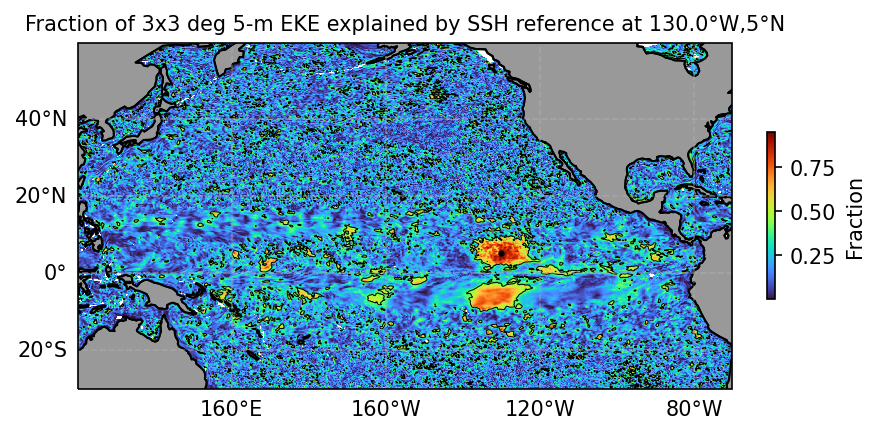

In [23]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 3x3 deg 5-m EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()

## 3x3 deg ave 5m u,v

In [10]:
path='data/fft_pacific_5m_u_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/5m_u_v_5day/fft_u_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
lon = nc.variables['lon'][:]

lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

fft_u = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()

path='data/fft_pacific_5m_v_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/5m_u_v_5day/fft_v_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
fft_v = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]

path='data/fft_ssh_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39_3x3_ave.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

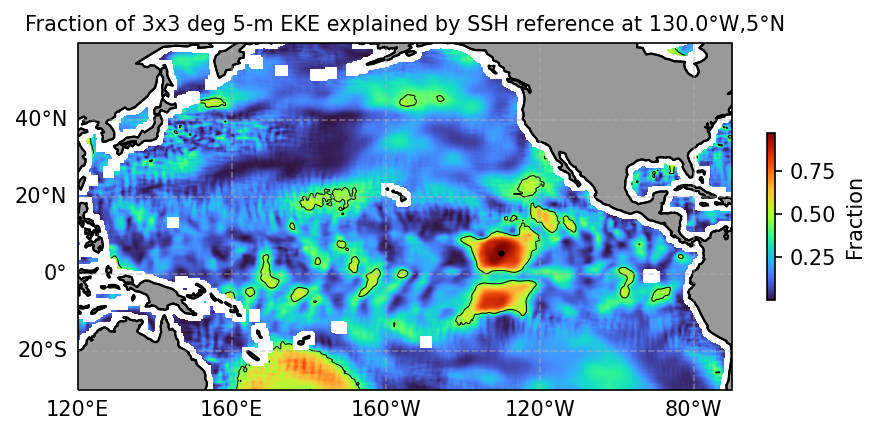

In [11]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 3x3 deg 5-m EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()

## 0.1 deg ave 5m u,v

In [12]:
path='data/fft_pacific_5m_u_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/5m_u_v_5day/fft_u_hann_26_39.nc'

nc=Dataset(path,'r')
lon = nc.variables['lon'][:]

lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

fft_u = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()

path='data/fft_pacific_5m_v_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/5m_u_v_5day/fft_v_hann_26_39.nc'

nc=Dataset(path,'r')
fft_v = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]


path='data/fft_ssh_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

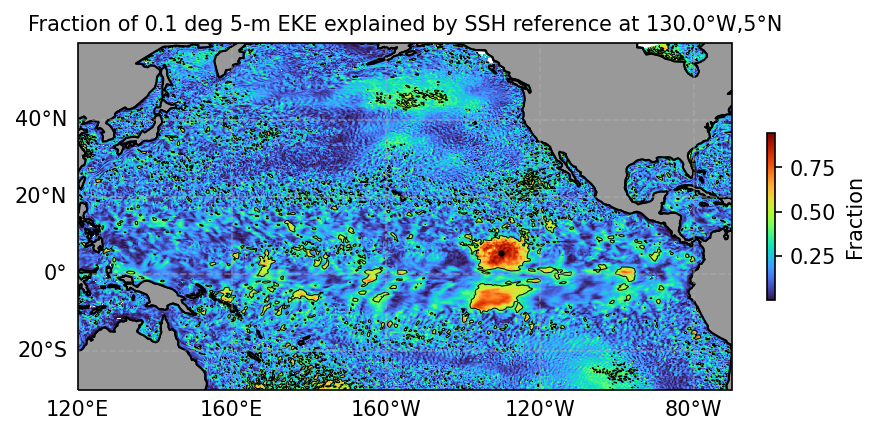

In [13]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 0.1 deg 5-m EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()

## 3x3 deg ave barotropic u,v

In [24]:
path='data/fft_bt_u_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_u_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
lon = nc.variables['lon'][:]

lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

fft_u = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()

path='data/fft_bt_v_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_v_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
fft_v = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]

path='data/fft_ssh_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39_3x3_ave.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

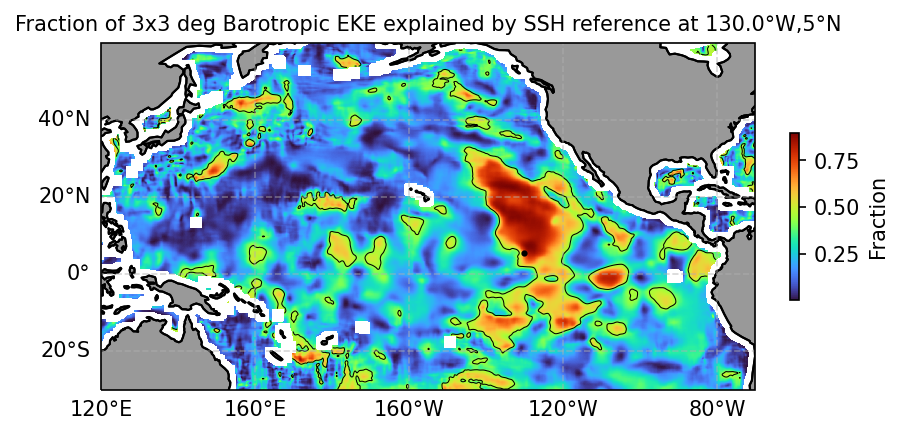

In [25]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 3x3 deg Barotropic EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()

## 0.1 deg barotropic u,v

In [26]:
path='data/fft_bt_u_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_u_hann_26_39.nc'
nc=Dataset(path,'r')
lon = nc.variables['lon'][:]

lon_plot=lon+ 360.*(lon<0)
lat_plot = nc.variables['lat'][:]

fft_u = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()
path='data/fft_bt_v_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_v_hann_26_39.nc'
nc=Dataset(path,'r')
fft_v = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()

N= 1022
dt = 5.#days
f_n = 1/(2*dt)
f = np.linspace(0.0, f_n, num=int((N)/2)+1) #frequencies of fft of u,v
df = f[1] - f[0]


path='data/fft_ssh_hann_26_39.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39.nc'
nc =Dataset(path,'r')
lat_ssh = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
lon_ssh =360*(lon<0)+lon
lon2d,lat2d=np.meshgrid(lon_ssh,lat_ssh)

#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

fft_ref = nc.variables['fft_h_real'][:,int(idx[0]),int(idx[1])]+\
          1j*nc.variables['fft_h_img'][:,int(idx[0]),int(idx[1])]

S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

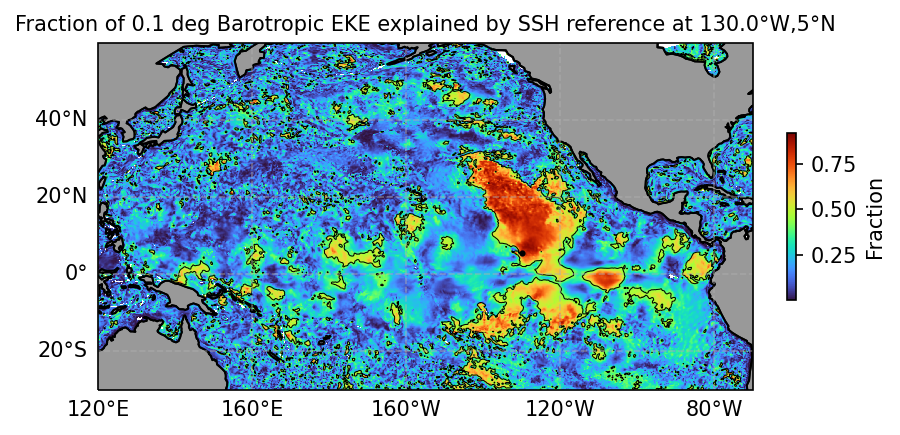

In [27]:
xmin, xmax = (lon_plot.min(),lon_plot.max())
ymin, ymax = (lat_plot.min(),lat_plot.max())
x0 = lon_ssh[int(idx[1])]
y0 = lat_ssh[int(idx[0])]

fig = plt.figure(dpi= 150 )
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=0.5*(lon_plot.min()+lon_plot.max())))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of 0.1 deg Barotropic EKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.pcolormesh(lon_plot,lat_plot,frac, shading = 'nearest',transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.012)
cb.set_label('Fraction',fontsize = 10)

# 0.44 is the error bar from the monte carlo simulation
plt.contour(lon_plot,lat_plot,frac,[0.44],colors= 'k',linewidths = 0.5,transform=ccrs.PlateCarree())

plt.plot(x0, y0, marker='o',color='k',transform=ccrs.PlateCarree(),markersize = 2);
#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/geo_EKE_frac_0.1deg.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()